# Understanding Tesco Mobile reviews on Trustpilot

The scope of this project includes:
* scraping reviews from TrustPilot
* training an NLP model to predict the sentiment of a new review 
* categorise reviews and track their scores over time 

In [1]:
# import basic modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

## Step 2: EDA

In [2]:
# load the dataset
data = pd.read_csv(
    '../data/tp_reviews_20180915_20200830.csv', 
    parse_dates=['published_date','updated_date','reported_date'])

# inspect
data.head()

,review_id,published_date,updated_date,reported_date,stars,review_text
0,5bb72dd69d37800b64319d20,2018-10-05 09:24:38+00:00,NaT,NaT,5,great service and on the one occasion i had a ...
1,5bb6969b9d37800b64317ffe,2018-10-04 22:39:23+00:00,NaT,NaT,5,Carl from the escalations team had a lovely ma...
2,5bb60cd49d37800734d8ad92,2018-10-04 12:51:32+00:00,NaT,NaT,4,Has been so straightforward since we switched ...
3,5bb2f4508c83fd0b58de76a2,2018-10-02 04:30:08+00:00,NaT,NaT,1,I made a very bad decision to sign a 12 month ...
4,5bb0b5048c83fd06e0c61921,2018-09-30 11:35:32+00:00,NaT,NaT,5,Quick advice and did the job efficiently!


In [3]:
# make sure that the dates have been correctly parsed as datetime64
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   review_id       800 non-null    object             
 1   published_date  800 non-null    datetime64[ns, UTC]
 2   updated_date    162 non-null    datetime64[ns, UTC]
 3   reported_date   0 non-null      datetime64[ns]     
 4   stars           800 non-null    int64              
 5   review_text     798 non-null    object             
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), int64(1), object(2)
memory usage: 37.6+ KB


#### Preprocessing

In [4]:
#
df = data.copy()

# drop columns that we won't need 
to_drop = ['updated_date','reported_date']
df.drop(columns=to_drop, axis=1, inplace=True)

# rename published_date
df.rename(columns={'published_date':'published_at'}, inplace=True)

# inspect 
df.head()

,review_id,published_at,stars,review_text
0,5bb72dd69d37800b64319d20,2018-10-05 09:24:38+00:00,5,great service and on the one occasion i had a ...
1,5bb6969b9d37800b64317ffe,2018-10-04 22:39:23+00:00,5,Carl from the escalations team had a lovely ma...
2,5bb60cd49d37800734d8ad92,2018-10-04 12:51:32+00:00,4,Has been so straightforward since we switched ...
3,5bb2f4508c83fd0b58de76a2,2018-10-02 04:30:08+00:00,1,I made a very bad decision to sign a 12 month ...
4,5bb0b5048c83fd06e0c61921,2018-09-30 11:35:32+00:00,5,Quick advice and did the job efficiently!


In [5]:
# create new datetime related features 
date_col = 'published_at'

date = pd.to_datetime(df[date_col].dt.date)
dow = df[date_col].dt.strftime('%a')
year = df[date_col].dt.strftime('%Y')
month_num = df[date_col].dt.strftime('%m')
yyyymm = year + month_num
weeknum = (df[date_col].dt.week).astype(str)
year_week = year + weeknum
hour = df[date_col].dt.strftime('%H')

In [6]:
# assign new date features to the DataFrame
df = df.assign(
    published_date=date,
    dow=dow,
    yyyymm=yyyymm,
    year_week=year_week,
    hour=hour)

# inspect
df.head()

,review_id,published_at,stars,review_text,published_date,dow,yyyymm,year_week,hour
0,5bb72dd69d37800b64319d20,2018-10-05 09:24:38+00:00,5,great service and on the one occasion i had a ...,2018-10-05,Fri,201810,201840,09
1,5bb6969b9d37800b64317ffe,2018-10-04 22:39:23+00:00,5,Carl from the escalations team had a lovely ma...,2018-10-04,Thu,201810,201840,22
2,5bb60cd49d37800734d8ad92,2018-10-04 12:51:32+00:00,4,Has been so straightforward since we switched ...,2018-10-04,Thu,201810,201840,12
3,5bb2f4508c83fd0b58de76a2,2018-10-02 04:30:08+00:00,1,I made a very bad decision to sign a 12 month ...,2018-10-02,Tue,201810,201840,04
4,5bb0b5048c83fd06e0c61921,2018-09-30 11:35:32+00:00,5,Quick advice and did the job efficiently!,2018-09-30,Sun,201809,201839,11


#### How many reviews are we getting and what's their sentiment?

In [7]:
# calculate basic weekly stats such as number of reviews and mean rating (1-5 stars)
grp = df.groupby('yyyymm')

# weekly_stats = grp.agg({'stars':['mean','count', lambda x: sum(x == 1)]}).reset_index() # old way: pandas <0.25

weekly_stats = grp.agg(
    reviews_num = ('stars', 'count'),
    mean_score = ('stars', 'mean'),
    one_star_num = ('stars', lambda x: sum(x == 1))).reset_index().round(2)

# flatten MultiIndex columns
# weekly_stats.columns = ['_'.join(col) for col in weekly_stats.columns.values]

# inspect 
weekly_stats.tail()

,yyyymm,reviews_num,mean_score,one_star_num
19,202004,29,2.17,17
20,202005,35,2.00,25
21,202006,44,1.52,35
22,202007,37,1.49,29
23,202008,53,1.47,44


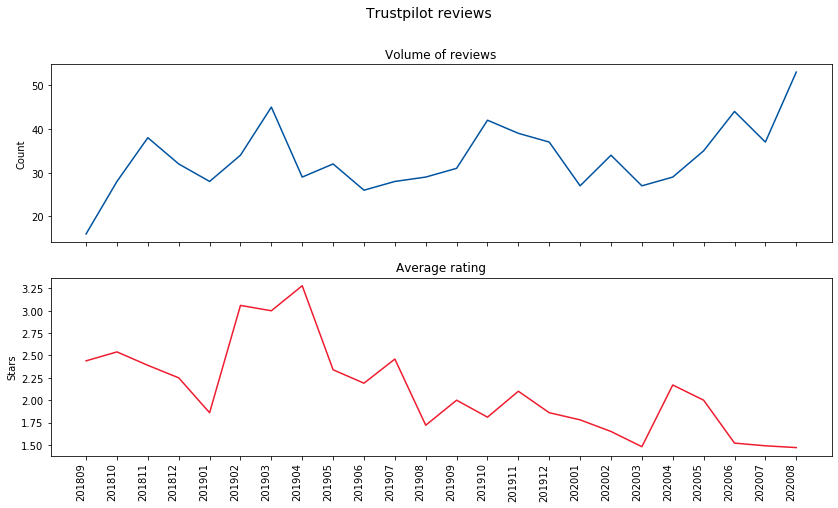

In [11]:
# visualise 
fig, ax = plt.subplots(2, figsize=(14,8))
fig.suptitle('Trustpilot reviews', fontsize=14)

# plot 
ax[0].plot(weekly_stats.yyyymm, weekly_stats.reviews_num, color='#00539f')
ax[1].plot(weekly_stats.yyyymm, weekly_stats.mean_score, color='#ee1c2e')

# annotate plots
ax[0].set_title('Volume of reviews')
ax[0].set_ylabel('Count')

ax[1].set_title('Average rating')
ax[1].set_ylabel('Stars')

# make it so that the x-axis is not overlapping
fig.autofmt_xdate(rotation=90)

#### More reviews are coming in 
* Trustpilot used to organically generate about ~`30-40` reviews per month. 
* Since `March 2020` that number has been steadily going up. 
* In August, we received `53` new reviews which was the highest number in at least 2 years. 

#### Most of them are complaints
* Most of our new reviews are `1` star reviews. 
* The average rating in August was only `1.47` stars which was our lowest average in at least 2 years. 